In [1]:
# Setup
import pandas as pd
import numpy as np
import datetime as dt

import glob
import os
import itertools
import collections
import re
import json
import requests
from shutil import copyfile
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import colour

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# https://matplotlib.org/3.1.0/tutorials/colors/colormap-manipulation.html

from shapely.geometry import Polygon, Point
import geopandas as gpd
import pyproj
import folium
from folium import Rectangle
from folium import Polygon as f_Polygon
import affine

from tqdm import tqdm # Progress bar stuff cos progress bars are good
tqdm.pandas() # now can use progress_apply instead of apply

import pickle # Pickle stuff, cos pickling is good

# Styles
pd.set_option('display.float_format', lambda x: '%.2f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

import rasterio
from rasterio.crs import CRS
from rasterio.plot import show
from rasterio.warp import transform_bounds
from rasterio.features import geometry_mask

from shapely.ops import transform
from functools import partial
import pyproj

In [4]:
base_dir = '/home/laurence/projects/raster-vision-fastai-plugin/data/duke_raw_labels/'

In [5]:
df = gpd.read_file(base_dir + 'SolarArrayPolygons.geojson')

In [8]:
df.head(1)

,polygon_id,centroid_latitude,centroid_longitude,centroid_latitude_pixels,centroid_longitude_pixels,city,area_pixels,area_meters,image_name,nw_corner_of_image_latitude,nw_corner_of_image_longitude,se_corner_of_image_latitude,se_corner_of_image_longitude,datum,projection_zone,resolution,jaccard_index,polygon_vertices_pixels,geometry
0,1,36.93,-119.84,107.62,3286.15,Fresno,136.19,1513.25,11ska460890,36.93,-119.85,36.91,-119.83,NAD83,11,0.30,0.91,"[ [ 3360.495069, 131.631164 ], [ 3249.197710, ...",POLYGON ((-119.8403028528537 36.92625126752494...


In [9]:
df.groupby('city').count()

,polygon_id,centroid_latitude,centroid_longitude,centroid_latitude_pixels,centroid_longitude_pixels,area_pixels,area_meters,image_name,nw_corner_of_image_latitude,nw_corner_of_image_longitude,se_corner_of_image_latitude,se_corner_of_image_longitude,datum,projection_zone,resolution,jaccard_index,polygon_vertices_pixels,geometry
city,,,,,,,,,,,,,,,,,,
Fresno,14710,14710,14710,14710,14710,14710,14710,14710,14710,14710,14710,14710,14710,14710,14710,14710,14710,14710
Modesto,582,582,582,582,582,582,582,582,582,582,582,582,582,582,582,582,582,582
Oxnard,1595,1595,1595,1595,1595,1595,1595,1595,1595,1595,1595,1595,1595,1595,1595,1595,1595,1595
Stockton,2546,2546,2546,2546,2546,2546,2546,2546,2546,2546,2546,2546,2546,2546,2546,2546,2546,2546


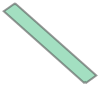

In [16]:
df.iloc[4].geometry

## Export GeoJson into named label files

In [22]:
df[df['image_name']=='11ska460890']

,polygon_id,centroid_latitude,centroid_longitude,centroid_latitude_pixels,centroid_longitude_pixels,city,area_pixels,area_meters,image_name,nw_corner_of_image_latitude,nw_corner_of_image_longitude,se_corner_of_image_latitude,se_corner_of_image_longitude,datum,projection_zone,resolution,jaccard_index,polygon_vertices_pixels,geometry
0,1,36.93,-119.84,107.62,3286.15,Fresno,136.19,1513.25,11ska460890,36.93,-119.85,36.91,-119.83,NAD83,11,0.30,0.91,"[ [ 3360.495069, 131.631164 ], [ 3249.197710, ...",POLYGON ((-119.8403028528537 36.92625126752494...
1,2,36.93,-119.84,45.98,3286.35,Fresno,155.51,1727.91,11ska460890,36.93,-119.85,36.91,-119.83,NAD83,11,0.30,0.83,"[ [ 3361.153846, 69.615385 ], [ 3217.615385, 1...",POLYGON ((-119.8403068380159 36.92641883215844...
2,3,36.93,-119.84,22.28,3303.47,Fresno,111.80,1242.18,11ska460890,36.93,-119.85,36.91,-119.83,NAD83,11,0.30,0.94,"[ [ 3358.015726, 48.136863 ], [ 3358.050000, 4...",POLYGON ((-119.8403195438845 36.92647659525593...
3,4,36.92,-119.84,2048.36,2547.37,Fresno,62.00,688.93,11ska460890,36.93,-119.85,36.91,-119.83,NAD83,11,0.30,0.84,"[ [ 2571.591716, 2068.049310 ], [ 2571.021266,...","POLYGON ((-119.842763429036 36.92095723433444,..."
4,5,36.92,-119.84,2060.01,2529.50,Fresno,95.48,1060.89,11ska460890,36.93,-119.85,36.91,-119.83,NAD83,11,0.30,0.89,"[ [ 2563.781065, 2091.398422 ], [ 2504.416174,...",POLYGON ((-119.8427873725915 36.92089353657303...
5,6,36.92,-119.84,2058.96,2501.53,Fresno,95.07,1056.37,11ska460890,36.93,-119.85,36.91,-119.83,NAD83,11,0.30,0.88,"[ [ 2536.550000, 2090.250000 ], [ 2508.358568,...","POLYGON ((-119.842879104718 36.92089444496381,..."
6,7,36.92,-119.84,2059.19,2474.75,Fresno,96.09,1067.70,11ska460890,36.93,-119.85,36.91,-119.83,NAD83,11,0.30,0.93,"[ [ 2508.437870, 2090.662722 ], [ 2508.012693,...",POLYGON ((-119.8429736450205 36.92089106555471...


In [23]:
for name in df['image_name'].unique():
    df[df['image_name'] == name].to_file(f"/home/laurence/projects/raster-vision-fastai-plugin/data/duke_labels/{name}.geojson", driver='GeoJSON')

In [38]:
# Get list of IDs
lab_dir = '/home/laurence/projects/raster-vision-fastai-plugin/data/duke_labels/*.geojson'

In [44]:
names = [os.path.basename(x).replace('.geojson', '') for x in glob.glob(lab_dir)]

In [46]:
names[0]

'11ska385710'

In [47]:
label_uri = '/home/laurence/projects/raster-vision-fastai-plugin/data/duke_labels/'

In [49]:
os.path.join(label_uri, '*.geojson')

'/home/laurence/projects/raster-vision-fastai-plugin/data/duke_labels/*.geojson'